# Init

In [1]:
import datasets
from datasets import load_dataset, Sequence, Image, DatasetDict, concatenate_datasets, Dataset
import os
import json
from tqdm import tqdm
import re
import copy
import pandas as pd
import numpy as np
from typing import Union, List
import ast
import linecache
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

/home/yuxiang/anaconda3/envs/arrg_preprocessing/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Ontology

In [2]:
class OntologyNode:
    def __init__(self, row_idx, class_id, class_name, df_row):
        self.row_idx = row_idx
        self.class_id = class_id
        self.class_name = class_name
        self.synonyms = [] if df_row["Synonyms"] == "" else df_row["Synonyms"].split("|")
        self.df_row = df_row

        # The tree structure is maintained by the parent and children attributes. Only one level of parent-child relationship is maintained.
        self.parent = []
        self.children = []
        self.is_root = False
        self.tree_level = None

        # It's parents from all levels
        self._all_parents = []

    def add_child(self, child):
        self.children.append(child)

    def add_parent(self, parent):
        self.parent.append(parent)

    @property
    def all_parents(self):
        if self.is_root:
            return []
        elif self._all_parents:
            return self._all_parents
        else:
            for parent in self.parent:
                # 避免父节点重复
                self._all_parents = set(parent.all_parents + [parent])
                self._all_parents = list(self._all_parents)
            return self._all_parents

    def __eq__(self, other):
        if isinstance(other, OntologyNode):
            return self.class_id == other.class_id
        else:
            return self.class_id == other

    def __hash__(self):
        return hash(self.class_id)

    def __str__(self):
        return f"{self.class_id}: {self.class_name}"

    def __repr__(self):
        return self.__str__()


def set_tree_level(curr_node, tree_level):
    curr_node.tree_level = tree_level
    for child in curr_node.children:
        set_tree_level(child, tree_level + 1)
    if not curr_node.children:
        return

In [3]:
def build_radlex_tree(df_csv):
    # Build a RadLex node list
    node_list = []
    root_node = None
    for idx, row in tqdm(df_csv.iterrows(), total=df_csv.shape[0], desc="Building RadLex tree"):
        ontology_node = OntologyNode(row_idx=idx, class_id=row["Class ID"], class_name=row["Preferred Label"], df_row=row)
        if row["Preferred Label"] in row["Class ID"]:
            ontology_node.class_name = row["http://radlex.org/RID/Preferred_Name_for_Obsolete"]
        node_list.append(ontology_node)

    # Resolve the node list and build a RadLex tree
    for node in tqdm(node_list, total=len(node_list), desc="Building RadLex tree"):
        df_row = node.df_row
        parent_ids = df_row["Parents"].split("|")
        for parent_id in parent_ids:
            parent_row_indices = df_csv.loc[df_csv["Class ID"] == parent_id].index
            if not parent_row_indices.empty:
                parent_row_idx = parent_row_indices[0]
                parent_node = node_list[parent_row_idx]
                assert parent_node.class_id == parent_id
                node.add_parent(parent_node)
                parent_node.add_child(node)
            else:
                # In radlex, http://radlex.org/RID/RID0 has parent http://www.w3.org/2002/07/owl#Thing.
                # However, the RID0 is already the root node in the RadLex ontology. We can safely ignore the owl#Thing.
                root_node = node
                node.is_root = True
                node.tree_level = 0

    return node_list, root_node

In [4]:
radlex_csv_path = "/home/yuxiang/liao/resources/bioportal/radlex/RADLEX.csv"
df_radlex_csv = pd.read_csv(radlex_csv_path, keep_default_na=False)
radlex_nodes, radlex_root_node = build_radlex_tree(df_radlex_csv)
radlex_nodes_dict = {node.class_id: node for node in radlex_nodes}
print(f"Number of RadLex nodes: {len(radlex_nodes)}")

# Tracing all parents of nodes
for node in radlex_nodes:
    node.all_parents

set_tree_level(radlex_root_node, tree_level=0)

Building RadLex tree: 100%|██████████| 46761/46761 [01:10<00:00, 664.48it/s]


Number of RadLex nodes: 46761


In [5]:
print(radlex_nodes[0])
print(radlex_nodes[0].parent)
print(radlex_nodes[0]._all_parents)

http://radlex.org/RID/RID35591: string-of-pearls sign of bowel
[http://radlex.org/RID/RID29023: imaging sign]
[http://radlex.org/RID/RID5: imaging observation, http://radlex.org/RID/RID0: RadLex ontology entity, http://radlex.org/RID/RID29023: imaging sign, http://radlex.org/RID/RID1: RadLex entity]


# Analyse

In [6]:
data_path = "/home/yuxiang/liao/workspace/arrg_preprocessing/outputs/interpret_sents/combined_results/combine_final"
ds = datasets.load_from_disk(data_path)
ds

Dataset({
    features: ['doc_key', 'sent_toks', 'tok_char_indices', 'sents', 'sent_char_indices', 'split_sents', 'sent_idx_split_idx', 'split_sent_toks', 'split_tok_char_indices', 'radlex', 'cxrgraph_ent', 'cxrgraph_attr', 'cxrgraph_rel', 'radcoref'],
    num_rows: 1136366
})

In [7]:
radlex_dockey_dict = defaultdict(list)
radlex_sentkey_dict = defaultdict(list)

for data_row in tqdm(ds):
    doc_key = data_row["doc_key"]  # train#0#impression
    for sent_idx, sent in enumerate(data_row["radlex"]):
        for radlex_item in sent:
            # {"char_indices": [20, 31], "match_type": "fuzzy_lemma", "matched_text": "parenchymal", "radlex_id": "http://radlex.org/RID/RID5978", "radlex_name": "parenchyma", "tok_indices": [2, 3]}
            radlex_node = radlex_nodes_dict[radlex_item["radlex_id"]]
            radlex_dockey_dict[radlex_node].append(doc_key)
            radlex_sentkey_dict[radlex_node].append((doc_key, sent_idx))

100%|██████████| 1136366/1136366 [10:25<00:00, 1817.79it/s]


In [60]:
def draw_bar_chart(target_data_dict, threshold=None, top_percent=None, level=None):

    if level:
        labels = [node.class_name for node in target_data_dict.keys() if node.tree_level == level]
        counts = [len(set(ids)) for node, ids in target_data_dict.items() if node.tree_level == level]
    else:
        labels = [node.class_name for node in target_data_dict.keys()]
        counts = [len(set(ids)) for ids in target_data_dict.values()]

    sorted_labels, sorted_counts = zip(*sorted(zip(labels, counts), key=lambda x: x[1], reverse=True))

    if threshold:
        sorted_counts = [count for count in sorted_counts if count > threshold]
        sorted_labels = sorted_labels[: len(sorted_counts)]

    if top_percent:
        top_n = int(len(sorted_labels) * top_percent)
        sorted_labels = sorted_labels[:top_n]
        sorted_counts = sorted_counts[:top_n]

    # Convert back to lists if needed
    sorted_labels = list(sorted_labels)
    sorted_counts = list(sorted_counts)

    # Create the bar chart
    # if len(sorted_labels) > 10:
    #     plt.figure(figsize=(10, len(sorted_labels) * 0.2))
    plt.barh(sorted_labels, sorted_counts, color="skyblue")
    plt.xlabel("Counts")
    plt.ylabel("RadLex Entities")
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest count on top
    plt.show()
    return sorted_labels, sorted_counts


def list_nodes(labels, counts, denominator=None):
    for label, count in zip(labels, counts):
        if denominator:
            print(f"{label}: {count} ({count / denominator:.2%})")
        else:
            print(f"{label}: {count}")

## Visualize by node level

In [9]:
inclusive = {
    "http://radlex.org/RID/RID5": "imaging observation",
    "http://radlex.org/RID/RID34861": "object",
    "http://radlex.org/RID/RID1559": "procedure",
    "http://radlex.org/RID/RID3": "anatomical entity",
    "http://radlex.org/RID/RID6": "RadLex descriptor",
    "http://radlex.org/RID/RID34785": "clinical finding",
    "http://radlex.org/RID/RID35977": "property",
}


node_dockey_dict = defaultdict(set)
for node, values in radlex_dockey_dict.items():
    # Check if the node or its parents is in the inclusive list
    if any([cls_id in node.all_parents or cls_id == node.class_id for cls_id in inclusive.keys()]):

        # 子节点的统计值会向上传播给父节点
        involved_nodes = node.all_parents + [node]
        for inv_node in involved_nodes:
            node_dockey_dict[inv_node].update(values)

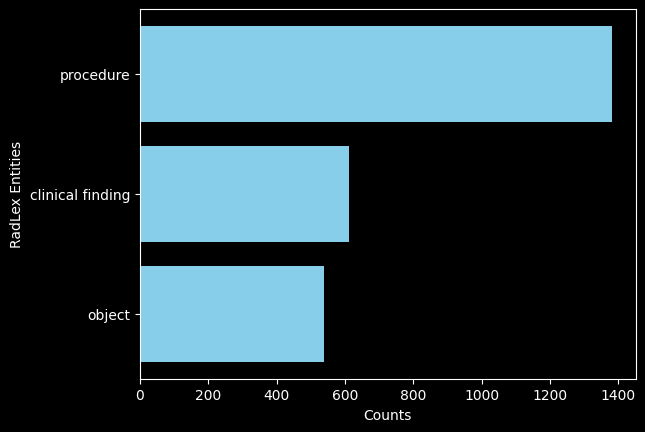

procedure: 1382
clinical finding: 613
object: 538


In [61]:
labels, counts = draw_bar_chart(node_dockey_dict, level=2)
list_nodes(labels, counts)

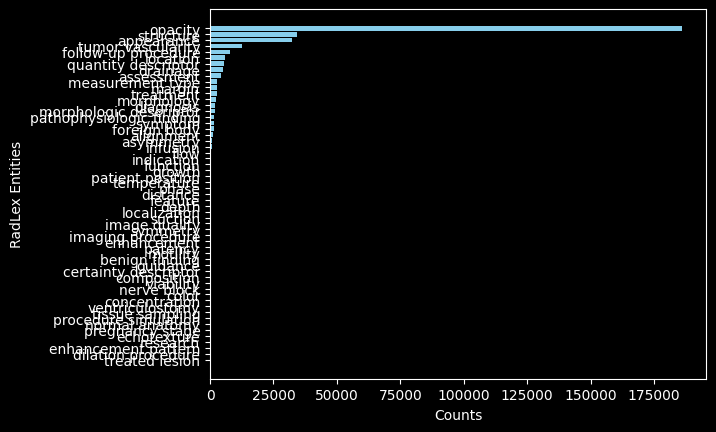

opacity: 186189
structure: 34441
appearance: 32302
tumor vascularity: 12546
follow-up procedure: 7999
location: 5734
quantity descriptor: 5448
drainage: 5161
assessment: 4406
measurement type: 2939
margin: 2882
treatment: 2599
morphology: 2412
diagnosis: 2139
morphologic descriptor: 1782
pathophysiologic finding: 1762
symptom: 1638
foreign body: 1497
alignment: 1013
asymmetry: 877
infusion: 833
flow: 549
indication: 544
function: 435
growth: 434
patient position: 400
temperature: 359
phase: 207
distance: 198
feature: 179
depth: 131
localization: 124
suction: 118
image quality: 47
symmetry: 43
imaging procedure: 29
enhancement: 28
patency: 21
motility: 20
benign finding: 16
guidance: 14
certainty descriptor: 14
composition: 7
viability: 5
nerve block: 4
color: 3
concentration: 3
ventriculostomy: 3
tissue sampling: 2
procedure simulation: 2
normal anatomy: 2
pregnancy stage: 1
echotexture: 1
research: 1
enhancement pattern: 1
dilation procedure: 1
treated lesion: 1


In [62]:
labels, counts = draw_bar_chart(node_dockey_dict, level=3)
list_nodes(labels, counts)

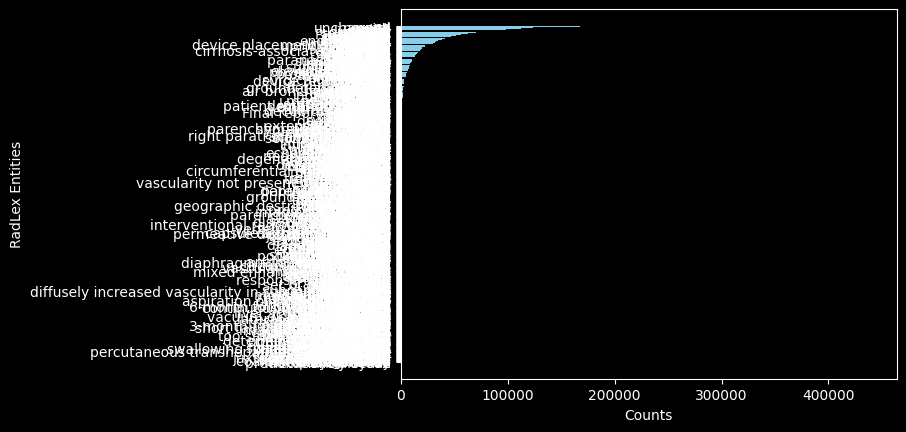

no: 441816
normal: 167589
unchanged: 131917
with: 123947
small: 113307
stable: 112330
mild: 110556
acute: 98063
lower: 96411
volume: 95818
diameter: 93693
upper: 80726
present: 75372
PtChanged: 73287
low: 69941
lateral: 64333
limited: 62807
previous: 57243
moderate: 56635
increased: 53621
persistent: 52021
possibly: 51987
interstitial: 47384
without: 46580
vascular: 45464
central: 44832
patient: 43364
new: 41662
osseous: 39232
endotracheal: 38741
increasing: 36706
infiltrate: 34911
improved: 32871
enlarged: 32665
large: 32330
single: 31662
nasogastric: 30349
device placement procedure: 30228
apical: 26530
upright position: 25861
after: 24425
minimal: 24274
laterality: 23000
basilar: 22567
superior: 22448
probably: 20722
distal: 19856
both: 19826
worsening: 19716
chronic: 19364
cirrhosis-associated nodules: 19294
decreased: 18598
angle: 18326
intact: 16627
suggestive: 16224
decreasing: 16051
definite: 15975
calcified: 15902
reticular: 15827
fractured: 15206
multiple: 15134
perihilar: 14

In [63]:
labels, counts = draw_bar_chart(node_dockey_dict, level=4)
list_nodes(labels, counts)

## Visualize by parent node type

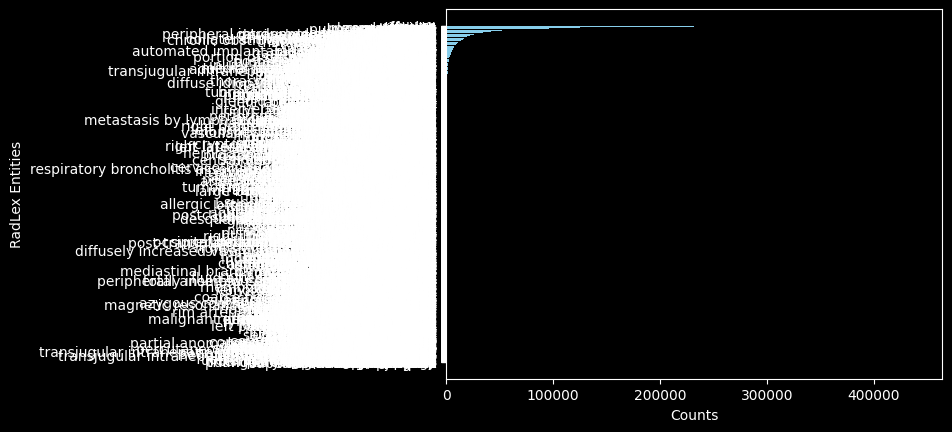

no: 441816
effusion: 341963
right: 305593
pleural effusion: 301986
left: 282940
pneumothorax: 232140
lung: 214055
opacity: 186189
thorax: 178637
normal: 167589
consolidation: 163199
edema: 162853
atelectasis: 159091
pulmonary edema: 131990
unchanged: 131917
tube: 124853
with: 123947
small: 113307
stable: 112330
bilateral: 111310
mild: 110556
lungs: 105330
clear: 101211
acute: 98063
lower: 96411
volume: 95818
diameter: 93693
focal: 92871
pneumonia: 81778
heart: 81058
lining: 80985
upper: 80726
lobe: 77681
present: 75372
PtChanged: 73287
low: 69941
catheter: 67949
lateral: 64333
contour: 64226
limited: 62807
base: 61517
previous: 57243
moderate: 56635
increased: 53621
persistent: 52021
possibly: 51987
interstitial: 47384
without: 46580
breast mass: 45821
vascular: 45464
central: 44832
patient: 43364
right lung: 43247
new: 41662
left lung: 41577
portable: 41401
osseous: 39232
nasogastric tube: 39048
endotracheal: 38741
endotracheal tube: 38432
parenchyma: 37674
increasing: 36706
caudomedi

In [13]:
inclusive = {
    "http://radlex.org/RID/RID5": "imaging observation",
    "http://radlex.org/RID/RID34861": "object",
    "http://radlex.org/RID/RID1559": "procedure",
    "http://radlex.org/RID/RID3": "anatomical entity",
    "http://radlex.org/RID/RID6": "RadLex descriptor",
    "http://radlex.org/RID/RID34785": "clinical finding",
    "http://radlex.org/RID/RID35977": "property",
}


node_dockey_dict = defaultdict(set)
for node, values in radlex_dockey_dict.items():
    # Check if the node or its parents is in the inclusive list
    if any([cls_id in node.all_parents or cls_id == node.class_id for cls_id in inclusive.keys()]):
        node_dockey_dict[node].update(values)

labels, counts = draw_bar_chart(node_dockey_dict)
list_nodes(labels, counts)

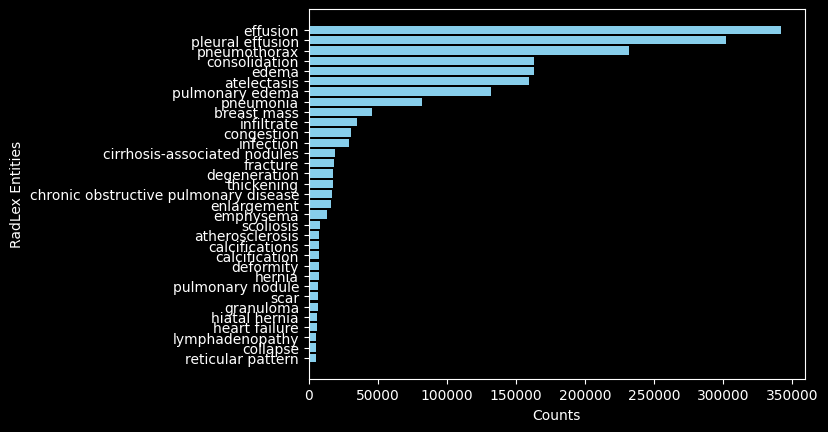

effusion: 341963
pleural effusion: 301986
pneumothorax: 232140
consolidation: 163199
edema: 162853
atelectasis: 159091
pulmonary edema: 131990
pneumonia: 81778
breast mass: 45821
infiltrate: 34911
congestion: 30305
infection: 29161
cirrhosis-associated nodules: 19294
fracture: 18085
degeneration: 17194
thickening: 17182
chronic obstructive pulmonary disease: 16749
enlargement: 15976
emphysema: 13451
scoliosis: 8004
atherosclerosis: 7443
calcifications: 7417
calcification: 7378
deformity: 7216
hernia: 7114
pulmonary nodule: 6724
scar: 6637
granuloma: 6590
hiatal hernia: 6069
heart failure: 5667
lymphadenopathy: 5429
collapse: 5378
reticular pattern: 5056


In [14]:
inclusive = {
    "http://radlex.org/RID/RID5": "imaging observation",
    "http://radlex.org/RID/RID34785": "clinical finding",
}


node_dockey_dict = defaultdict(set)
for node, values in radlex_dockey_dict.items():
    # Check if the node or its parents is in the inclusive list
    if any([cls_id in node.all_parents or cls_id == node.class_id for cls_id in inclusive.keys()]):
        node_dockey_dict[node].update(values)

labels, counts = draw_bar_chart(node_dockey_dict, threshold=5000)
list_nodes(labels, counts)

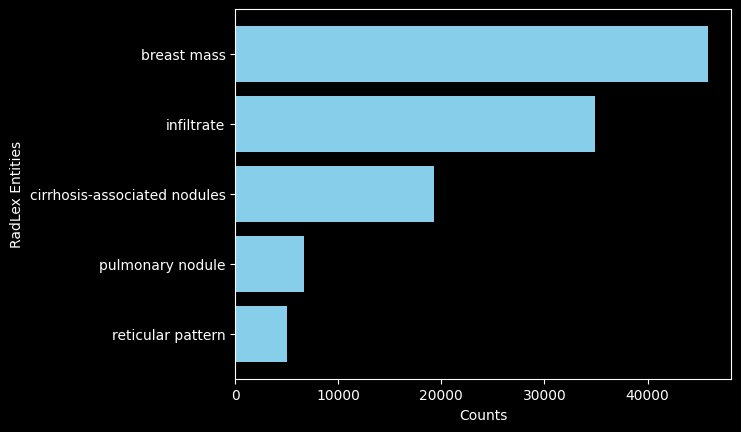

breast mass: 45821
infiltrate: 34911
cirrhosis-associated nodules: 19294
pulmonary nodule: 6724
reticular pattern: 5056


In [15]:
inclusive = {
    "http://radlex.org/RID/RID5": "imaging observation",
}


node_dockey_dict = defaultdict(set)
for node, values in radlex_dockey_dict.items():
    # Check if the node or its parents is in the inclusive list
    if any([cls_id in node.all_parents or cls_id == node.class_id for cls_id in inclusive.keys()]):
        node_dockey_dict[node].update(values)

labels, counts = draw_bar_chart(node_dockey_dict, threshold=5000)
list_nodes(labels, counts)

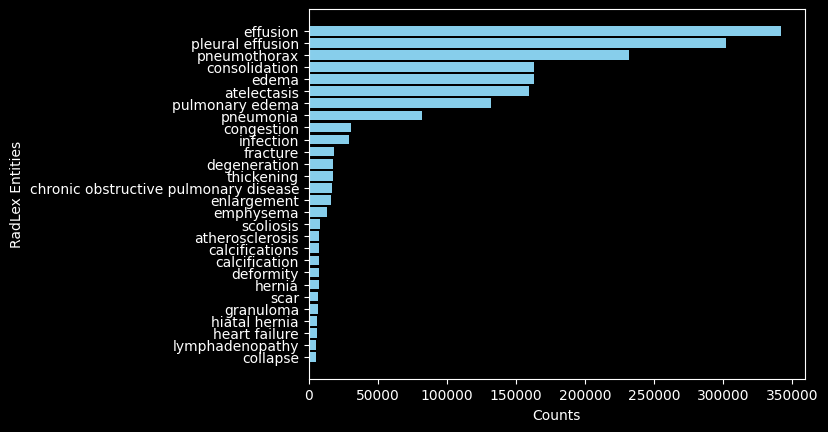

effusion: 341963
pleural effusion: 301986
pneumothorax: 232140
consolidation: 163199
edema: 162853
atelectasis: 159091
pulmonary edema: 131990
pneumonia: 81778
congestion: 30305
infection: 29161
fracture: 18085
degeneration: 17194
thickening: 17182
chronic obstructive pulmonary disease: 16749
enlargement: 15976
emphysema: 13451
scoliosis: 8004
atherosclerosis: 7443
calcifications: 7417
calcification: 7378
deformity: 7216
hernia: 7114
scar: 6637
granuloma: 6590
hiatal hernia: 6069
heart failure: 5667
lymphadenopathy: 5429
collapse: 5378


In [16]:
inclusive = {
    "http://radlex.org/RID/RID34785": "clinical finding",
}

node_dockey_dict = defaultdict(set)
for node, values in radlex_dockey_dict.items():
    # Check if the node or its parents is in the inclusive list
    if any([cls_id in node.all_parents or cls_id == node.class_id for cls_id in inclusive.keys()]):
        node_dockey_dict[node].update(values)

labels, counts = draw_bar_chart(node_dockey_dict, threshold=5000)
list_nodes(labels, counts)

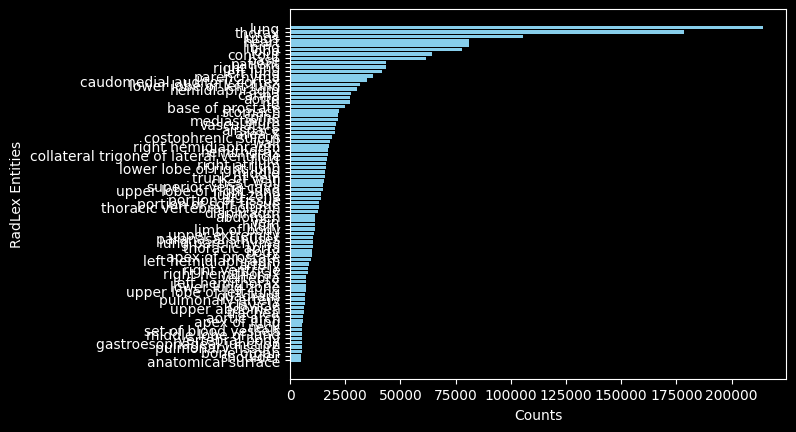

lung: 214055
thorax: 178637
lungs: 105330
heart: 81058
lining: 80985
lobe: 77681
contour: 64226
base: 61517
patient: 43364
right lung: 43247
left lung: 41577
parenchyma: 37674
caudomedial auditory cortex: 34927
lower lobe of left lung: 31517
hemidiaphragm: 30421
carina: 27362
aorta: 27324
rib: 27102
base of prostate: 24830
stomach: 22258
spine: 21901
mediastinum: 21739
vasculature: 20936
airspace: 20350
area X: 20281
costophrenic sulcus: 18770
wall: 18018
right hemidiaphragm: 17713
hemithorax: 17235
collateral trigone of lateral ventricle: 16939
fluid: 16504
right atrium: 16167
lower lobe of right lung: 16064
middle: 16017
trunk of vein: 15679
chest wall: 15392
superior vena cava: 14982
upper lobe of right lung: 14875
lung zone: 14167
portion of tissue: 13925
portion of soft tissue: 13206
thoracic vertebral column: 13204
diaphragm: 12445
abdomen: 11466
vein: 11314
hilum: 11297
limb of body: 11151
upper extremity: 10902
paranasal sinuses: 10507
lung parenchyma: 10462
thoracic aorta: 102

In [17]:
inclusive = {
    "http://radlex.org/RID/RID3": "anatomical entity",
}


node_dockey_dict = defaultdict(set)
for node, values in radlex_dockey_dict.items():
    # Check if the node or its parents is in the inclusive list
    if any([cls_id in node.all_parents or cls_id == node.class_id for cls_id in inclusive.keys()]):
        node_dockey_dict[node].update(values)

labels, counts = draw_bar_chart(node_dockey_dict, threshold=5000)
list_nodes(labels, counts)

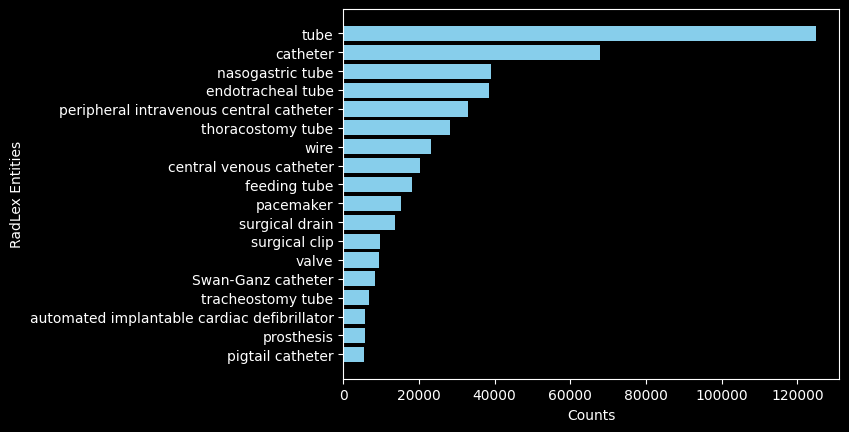

tube: 124853
catheter: 67949
nasogastric tube: 39048
endotracheal tube: 38432
peripheral intravenous central catheter: 33066
thoracostomy tube: 28124
wire: 23100
central venous catheter: 20382
feeding tube: 18166
pacemaker: 15359
surgical drain: 13550
surgical clip: 9774
valve: 9375
Swan-Ganz catheter: 8409
tracheostomy tube: 6714
automated implantable cardiac defibrillator: 5764
prosthesis: 5662
pigtail catheter: 5372


In [18]:
inclusive = {
    "http://radlex.org/RID/RID34861": "object",
}


node_dockey_dict = defaultdict(set)
for node, values in radlex_dockey_dict.items():
    # Check if the node or its parents is in the inclusive list
    if any([cls_id in node.all_parents or cls_id == node.class_id for cls_id in inclusive.keys()]):
        node_dockey_dict[node].update(values)

labels, counts = draw_bar_chart(node_dockey_dict, threshold=5000)
list_nodes(labels, counts)

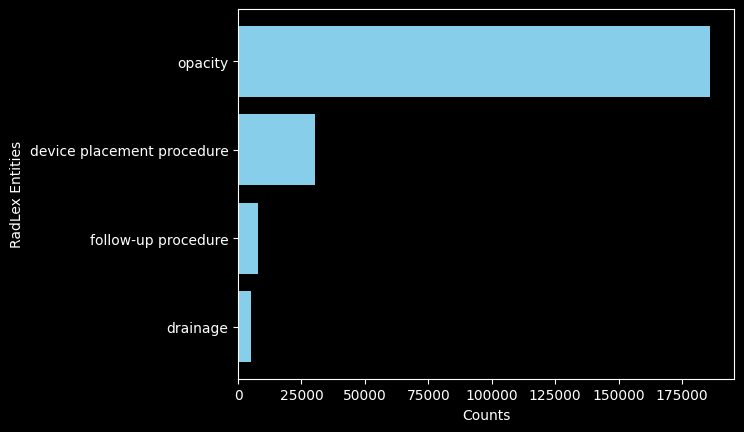

opacity: 186189
device placement procedure: 30228
follow-up procedure: 7999
drainage: 5161


In [19]:
inclusive = {
    "http://radlex.org/RID/RID1559": "procedure",
}


node_dockey_dict = defaultdict(set)
for node, values in radlex_dockey_dict.items():
    # Check if the node or its parents is in the inclusive list
    if any([cls_id in node.all_parents or cls_id == node.class_id for cls_id in inclusive.keys()]):
        node_dockey_dict[node].update(values)

labels, counts = draw_bar_chart(node_dockey_dict, threshold=5000)
list_nodes(labels, counts)

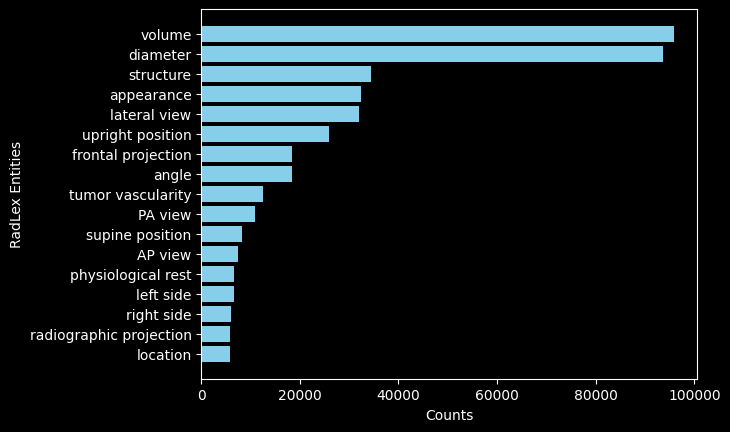

volume: 95818
diameter: 93693
structure: 34441
appearance: 32302
lateral view: 32052
upright position: 25861
frontal projection: 18466
angle: 18326
tumor vascularity: 12546
PA view: 10848
supine position: 8228
AP view: 7447
physiological rest: 6679
left side: 6589
right side: 5952
radiographic projection: 5889
location: 5734


In [20]:
inclusive = {
    "http://radlex.org/RID/RID35977": "property",
}


node_dockey_dict = defaultdict(set)
for node, values in radlex_dockey_dict.items():
    # Check if the node or its parents is in the inclusive list
    if any([cls_id in node.all_parents or cls_id == node.class_id for cls_id in inclusive.keys()]):
        node_dockey_dict[node].update(values)

labels, counts = draw_bar_chart(node_dockey_dict, threshold=5000)
list_nodes(labels, counts)

## Statistic

train, dev, test

In [21]:
# 句子数量
num_reports = len(ds)
print(f"Number of reports in the dataset {num_reports:,}")

Number of reports in the dataset 1,136,366


In [22]:
num_empty_reports = 0
for data_row in tqdm(ds.select_columns("sents")):
    if not data_row["sents"]:
        num_empty_reports += 1

print(f"Number of empty reports: {num_empty_reports:,}")
num_not_empty_reports = num_reports - num_empty_reports
print(f"Number of not empty reports: {num_not_empty_reports:,}")

  0%|          | 0/1136366 [00:00<?, ?it/s]

100%|██████████| 1136366/1136366 [00:11<00:00, 101493.85it/s]

Number of empty reports: 401,730
Number of not empty reports: 734,636


In [23]:
num_sents = 0
num_split_sents = 0
for data_row in tqdm(ds.select_columns(["sents", "split_sents"])):
    if data_row["sents"]:
        num_sents += len(data_row["sents"])
        assert data_row["split_sents"]
        num_split_sents += len(data_row["split_sents"])

print(f"Number of sentences: {num_sents:,}")
print(f"Number of split sentences: {num_split_sents:,}")

100%|██████████| 1136366/1136366 [00:19<00:00, 57909.07it/s]

Number of sentences: 2,872,770
Number of split sentences: 5,330,592


In [24]:
print(f"Average number of sentences per report: {num_sents / num_not_empty_reports:.2f}")
print(f"Average number of split sentences per report: {num_split_sents / num_not_empty_reports:.2f}")

Average number of sentences per report: 3.91
Average number of split sentences per report: 7.26


In [25]:
num_split_sents_with_radlex = 0
for data_row in tqdm(ds.select_columns(["radlex"])):
    for sent_radlex in data_row["radlex"]:
        if sent_radlex:
            num_split_sents_with_radlex += 1

print(f"Number of split sentences with RadLex entities: {num_split_sents_with_radlex:,}")
print(f"% of split sentences with RadLex entities: {num_split_sents_with_radlex/num_split_sents:.2%}")

100%|██████████| 1136366/1136366 [02:21<00:00, 8057.72it/s]

Number of split sentences with RadLex entities: 4,659,470
% of split sentences with RadLex entities: 87.41%


In [26]:
inclusive = {
    "http://radlex.org/RID/RID5": "imaging observation",
    "http://radlex.org/RID/RID34861": "object",
    "http://radlex.org/RID/RID1559": "procedure",
    "http://radlex.org/RID/RID3": "anatomical entity",
    "http://radlex.org/RID/RID6": "RadLex descriptor",
    "http://radlex.org/RID/RID34785": "clinical finding",
    "http://radlex.org/RID/RID35977": "property",
}

num_not_empty_reports_with_valid_radlex = 0
for data_row in tqdm(ds.select_columns(["split_sents", "radlex"])):
    if data_row["split_sents"]:
        for sent_radlex in data_row["radlex"]:
            is_sent_has_valid_radlex = False
            for radlex_item in sent_radlex:
                node = radlex_nodes_dict[radlex_item["radlex_id"]]
                if any([cls_id in node.all_parents or cls_id == node.class_id for cls_id in inclusive.keys()]):
                    is_sent_has_valid_radlex = True

            if is_sent_has_valid_radlex:
                num_not_empty_reports_with_valid_radlex += 1
                break

print(f"Number of not empty reports with RadLex entities: {num_not_empty_reports_with_valid_radlex:,}")
print(f"% of not empty reports with RadLex entities: {num_not_empty_reports_with_valid_radlex/num_not_empty_reports:.2%}")

100%|██████████| 1136366/1136366 [02:43<00:00, 6942.60it/s]

Number of not empty reports with RadLex entities: 733,093
% of not empty reports with RadLex entities: 99.79%


## 合并数据

100%|██████████| 297/297 [00:00<00:00, 376346.91it/s]


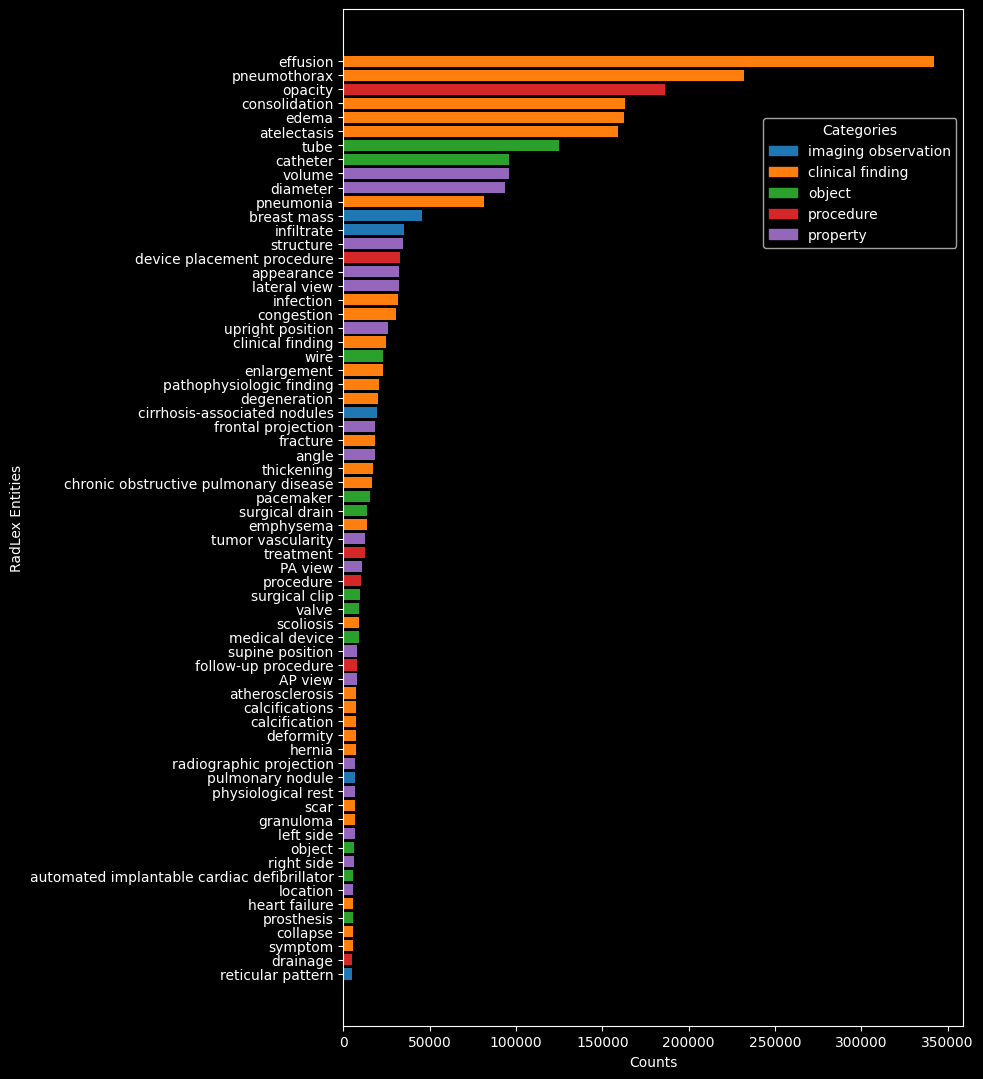

effusion: 341963
pneumothorax: 232140
opacity: 186549
consolidation: 163199
edema: 162853
atelectasis: 159091
tube: 124853
catheter: 95849
volume: 95818
diameter: 93693
pneumonia: 81778
breast mass: 45821
infiltrate: 34911
structure: 34441
device placement procedure: 32593
appearance: 32302
lateral view: 32052
infection: 31740
congestion: 30305
upright position: 25861
clinical finding: 24876
wire: 23100
enlargement: 22984
pathophysiologic finding: 20855
degeneration: 20015
cirrhosis-associated nodules: 19294
frontal projection: 18466
fracture: 18414
angle: 18326
thickening: 17182
chronic obstructive pulmonary disease: 16749
pacemaker: 15359
surgical drain: 13550
emphysema: 13451
tumor vascularity: 12644
treatment: 12634
PA view: 10848
procedure: 10450
surgical clip: 9774
valve: 9375
scoliosis: 9367
medical device: 9014
supine position: 8228
follow-up procedure: 7999
AP view: 7746
atherosclerosis: 7443
calcifications: 7417
calcification: 7378
deformity: 7216
hernia: 7114
radiographic pr

In [ ]:
inclusive = {
    "http://radlex.org/RID/RID5": "imaging observation",
    "http://radlex.org/RID/RID34785": "clinical finding",
    "http://radlex.org/RID/RID34861": "object",
    "http://radlex.org/RID/RID1559": "procedure",
    "http://radlex.org/RID/RID35977": "property",
    # "http://radlex.org/RID/RID3": "anatomical entity",
    # "http://radlex.org/RID/RID6": "RadLex descriptor",
}
colour_map = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]


node_dockey_dict = defaultdict(set)
for node, values in tqdm(radlex_dockey_dict.items()):
    # Check if the node or its parents is in the inclusive list
    if any([cls_id in node.all_parents or cls_id == node.class_id for cls_id in inclusive.keys()]):
        node_dockey_dict[node].update(values)


nodes = [node for node in node_dockey_dict.keys()]
dockey_sets = [set(ids) for ids in node_dockey_dict.values()]

# 按照node在报告中出现的次数排序
# 如果node的父节点已经出现过，那么就不再单独统计，而是将其涉及的doc_keys传递给父节点，并跳过当前node
aggregrated_nodes, aggregrated_dockey_sets = [], []
for node, key_set in tqdm(sorted(zip(nodes, dockey_sets), key=lambda x: len(x[1]), reverse=True)):

    is_parent_exist = False
    for parent_node in sorted(node.all_parents, key=lambda x: x.tree_level, reverse=True):
        if parent_node in aggregrated_nodes:
            idx = aggregrated_nodes.index(parent_node)
            aggregrated_dockey_sets[idx].update(key_set)
            is_parent_exist = True
            break

    if not is_parent_exist:
        aggregrated_nodes.append(node)
        aggregrated_dockey_sets.append(key_set)


labels, counts, colours = [], [], []
for node, key_set in tqdm(sorted(zip(aggregrated_nodes, aggregrated_dockey_sets), key=lambda x: len(x[1]), reverse=True)):
    labels.append(node.class_name)
    counts.append(len(key_set))
    for category_idx, category_node_id in enumerate(inclusive.keys()):
        if category_node_id in node.all_parents or category_node_id == node.class_id:
            colours.append(colour_map[category_idx])
            break
assert len(labels) == len(counts) == len(colours)

threshold = 5000
if threshold:
    counts = [count for count in counts if count > threshold]
    labels = labels[: len(counts)]
    colours = colours[: len(counts)]

# if top_percent:
#     top_n = int(len(labels) * top_percent)
#     labels = labels[:top_n]
#     counts = counts[:top_n]

# Create the bar chart
plt.figure(figsize=(8, len(labels) * 0.2))  # 动态调整高度，0.2 是每个条目的高度，可以调整

plt.barh(labels, counts, color=colours)
plt.xlabel("Counts")
plt.ylabel("RadLex Entities")
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count on top
# plt.tight_layout()  # 自动调整布局以防止重叠

legend_patches = [Patch(color=colour_map[category_idx], label=category_name) for category_idx, category_name in enumerate(inclusive.values())]
plt.legend(handles=legend_patches, title="Categories", loc="upper right", bbox_to_anchor=(1, 0.9))


plt.show()


for label, count in zip(labels, counts):
    print(f"{label}: {count}")

## Coverage

In [28]:
num_reports = len(ds)
num_not_empty_reports = 0
for data_row in tqdm(ds.select_columns("sents")):
    if data_row["sents"]:
        num_not_empty_reports += 1

100%|██████████| 1136366/1136366 [00:11<00:00, 100263.37it/s]


In [ ]:
inclusive = {
    "http://radlex.org/RID/RID5": "imaging observation",
    "http://radlex.org/RID/RID34785": "clinical finding",
    "http://radlex.org/RID/RID34861": "object",
    "http://radlex.org/RID/RID1559": "procedure",
    "http://radlex.org/RID/RID35977": "property",
    "http://radlex.org/RID/RID3": "anatomical entity",
    "http://radlex.org/RID/RID6": "RadLex descriptor",
}

node_dockey_dict = defaultdict(set)
for node, dockeys in tqdm(radlex_dockey_dict.items()):
    # Check if the node or its parents is in the inclusive list
    if any([cls_id in node.all_parents or cls_id == node.class_id for cls_id in inclusive.keys()]):
        node_dockey_dict[node].update(dockeys)

nodes = [node for node in node_dockey_dict.keys()]
dockey_sets = [set(ids) for ids in node_dockey_dict.values()]

# 按照node在报告中出现的次数排序
# 如果node的父节点已经出现过，那么就不再单独统计，而是将其涉及的doc_keys传递给父节点，并跳过当前node
aggregrated_nodes, aggregrated_dockey_sets = [], []
for node, key_set in tqdm(sorted(zip(nodes, dockey_sets), key=lambda x: len(x[1]), reverse=True)):
    is_parent_exist = False
    for parent_node in sorted(node.all_parents, key=lambda x: x.tree_level, reverse=True):
        if parent_node in aggregrated_nodes:
            idx = aggregrated_nodes.index(parent_node)
            aggregrated_dockey_sets[idx].update(key_set)
            is_parent_exist = True
            break

    if not is_parent_exist:
        aggregrated_nodes.append(node)
        aggregrated_dockey_sets.append(key_set)

nodes, dockey_sets = zip(*sorted(zip(aggregrated_nodes, aggregrated_dockey_sets), key=lambda x: len(x[1]), reverse=True))
assert len(nodes) == len(dockey_sets)

  0%|          | 0/3437 [00:00<?, ?it/s]

100%|██████████| 3279/3279 [00:01<00:00, 2806.92it/s]


In [30]:
inclusive = {
    "http://radlex.org/RID/RID5": "imaging observation",
    "http://radlex.org/RID/RID34785": "clinical finding",
    "http://radlex.org/RID/RID34861": "object",
    "http://radlex.org/RID/RID1559": "procedure",
    "http://radlex.org/RID/RID35977": "property",
    # "http://radlex.org/RID/RID3": "anatomical entity",
    # "http://radlex.org/RID/RID6": "RadLex descriptor",
}

colour_map = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]


# 二次过滤数据
labels, counts, colours = [], [], []
accumulate_dockey = set()
for node, key_set in zip(nodes, dockey_sets):
    if len(key_set) < 1000:
        continue

    # Check if the node or its parents is in the inclusive list
    if any([cls_id in node.all_parents or cls_id == node.class_id for cls_id in inclusive.keys()]):
        accumulate_dockey.update(key_set)
        print(f"{len(accumulate_dockey)/num_not_empty_reports:.2%} | {node.class_name}: {len(key_set)} | {node.class_id}")
        labels.append(node.class_name + f" ({len(key_set)} | {len(accumulate_dockey)/num_not_empty_reports:.2%})")
        counts.append(len(accumulate_dockey) / num_not_empty_reports)
        for category_idx, category_node_id in enumerate(inclusive.keys()):
            if category_node_id in node.all_parents or category_node_id == node.class_id:
                colours.append(colour_map[category_idx])
                break

46.55% | effusion: 341963 | http://radlex.org/RID/RID4872
55.02% | pneumothorax: 232140 | http://radlex.org/RID/RID5352
62.60% | opacity: 186549 | http://radlex.org/RID/RID28530
66.92% | consolidation: 163199 | http://radlex.org/RID/RID43255
70.35% | edema: 162853 | http://radlex.org/RID/RID4865
72.19% | atelectasis: 159091 | http://radlex.org/RID/RID28493
74.08% | tube: 124853 | http://radlex.org/RID/RID5555
74.78% | catheter: 95849 | http://radlex.org/RID/RID5576
75.43% | volume: 95818 | http://radlex.org/RID/RID28668
75.96% | diameter: 93693 | http://radlex.org/RID/RID13432
77.92% | pneumonia: 81778 | http://radlex.org/RID/RID5350
79.07% | breast mass: 45821 | http://radlex.org/RID/RID39055
80.44% | infiltrate: 34911 | http://radlex.org/RID/RID39317
80.57% | structure: 34441 | http://radlex.org/RID/RID35808
80.61% | device placement procedure: 32593 | http://radlex.org/RID/RID28707
80.79% | appearance: 32302 | http://radlex.org/RID/RID49903
80.90% | lateral view: 32052 | http://radl

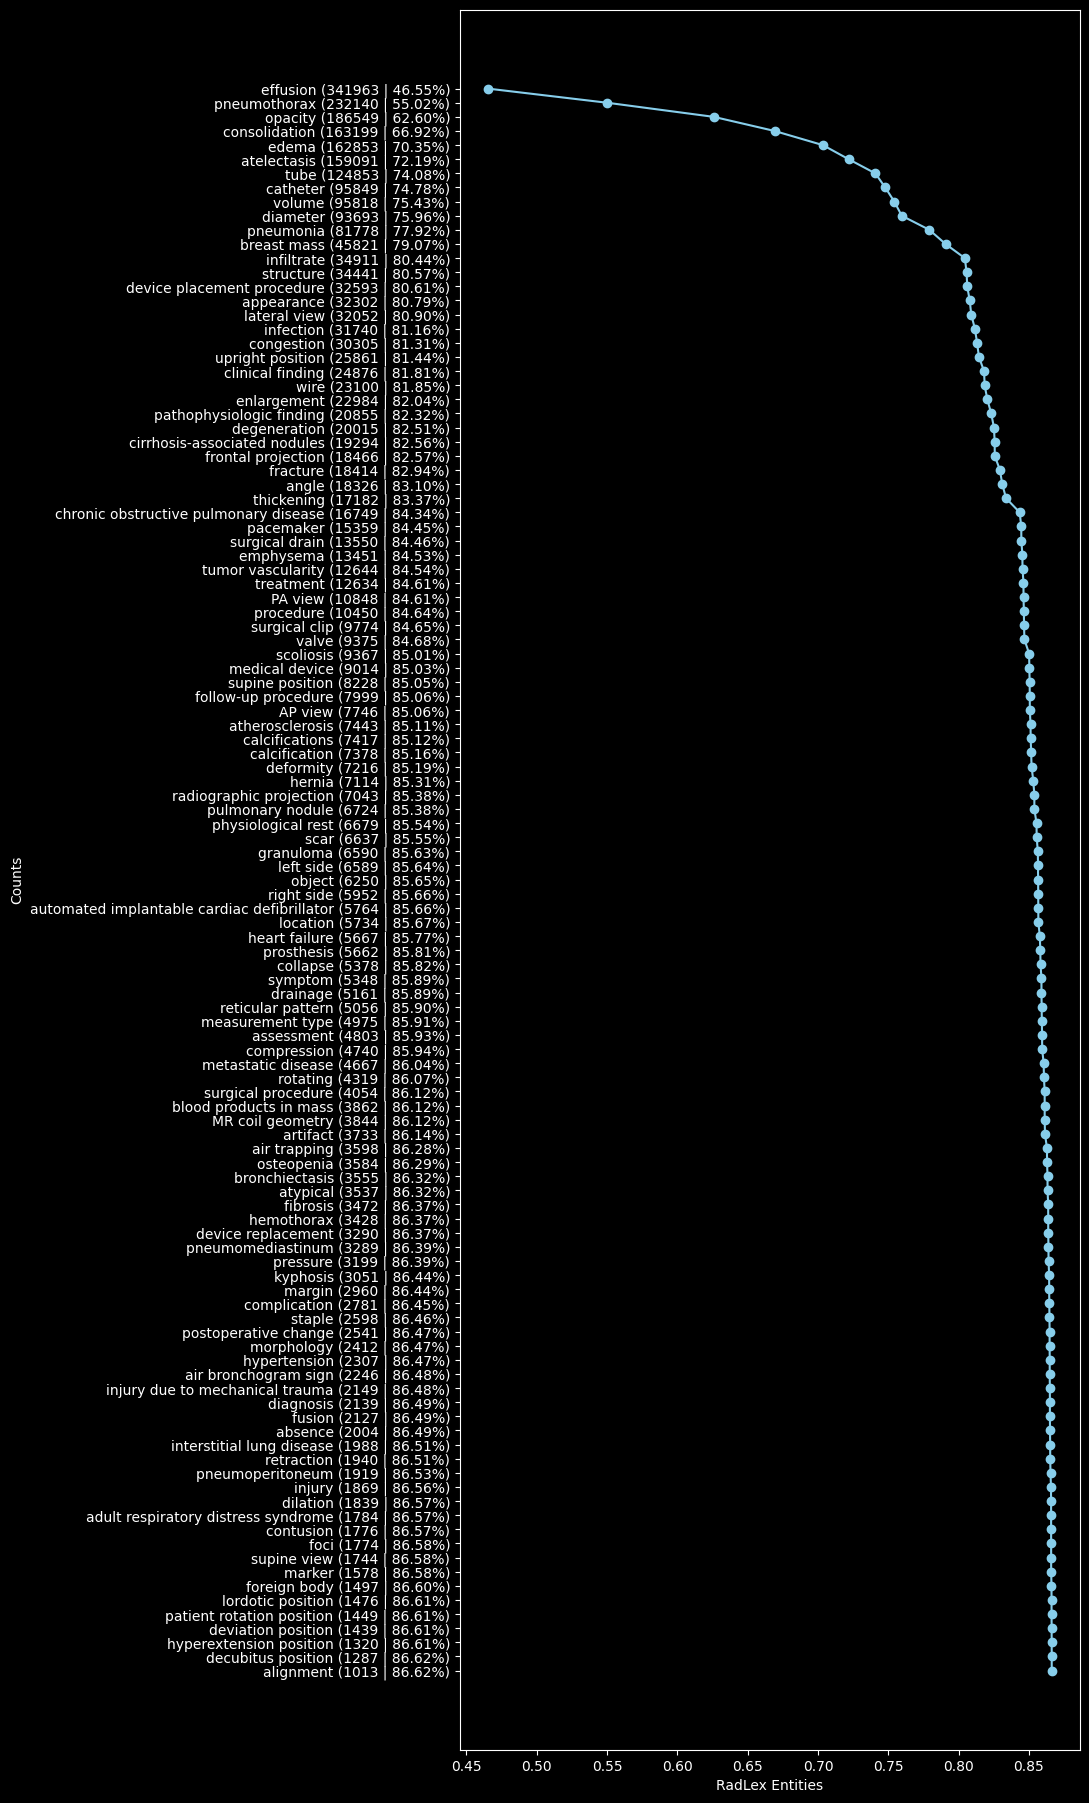

In [31]:
# Create the bar chart
plt.figure(figsize=(8, len(labels) * 0.2))  # 动态调整高度，0.2 是每个条目的高度，可以调整

plt.plot(counts, labels, "o-", color="skyblue")
plt.xlabel("RadLex Entities")
plt.ylabel("Counts")
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count on top
# plt.tight_layout()  # 自动调整布局以防止重叠

# legend_patches = [Patch(color=colour_map[category_idx], label=category_name) for category_idx, category_name in enumerate(inclusive.values())]
# plt.legend(handles=legend_patches, title="Categories", loc="upper right", bbox_to_anchor=(1, 0.9))